In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn

# Load dataframes
awards_players = pd.read_csv('../data/awards_players.csv')
coaches = pd.read_csv('../data/coaches.csv')
players_teams = pd.read_csv('../data/players_teams.csv')
players = pd.read_csv('../data/players.csv')
series_post = pd.read_csv('../data/series_post.csv')
teams_post = pd.read_csv('../data/teams_post.csv')
teams = pd.read_csv('../data/teams.csv')

In [27]:
# Cleaning Awards Players
# Drop lgID column since all values are 'WNBA'
awards_players.drop('lgID', axis=1, inplace=True)


#Add the missing "award" value for line 30
awards_players.at[28, 'award'] = "Kim Perrot Sportsmanship Award" 
awards_players.head(10)

,playerID,award,year
0,thompti01w,All-Star Game Most Valuable Player,1
1,leslili01w,All-Star Game Most Valuable Player,2
2,leslili01w,All-Star Game Most Valuable Player,3
3,teaslni01w,All-Star Game Most Valuable Player,4
4,swoopsh01w,All-Star Game Most Valuable Player,6
5,douglka01w,All-Star Game Most Valuable Player,7
6,fordch01w,All-Star Game Most Valuable Player,8
7,cashsw01w,All-Star Game Most Valuable Player,10
8,coopemi01w,Coach of the Year,1
9,hugheda99w,Coach of the Year,2


In [28]:
# We can drop 'lgID', since all values are 'WNBA'
players_teams.drop('lgID', axis=1, inplace=True)
players_teams.drop('rebounds', axis=1, inplace=True)
players_teams.drop('PostRebounds', axis=1, inplace=True)

In [29]:
# We can drop 'lgID', since all values are 'WNBA'
teams_post.drop('lgID', axis=1, inplace=True)

In [30]:
# We can drop 'lgIDWinner and 'lgIDLoser', since all values are 'WNBA'
series_post.drop(['lgIDWinner', 'lgIDLoser'], axis=1, inplace=True)

In [31]:
# We can drop 'lgID', since all values are 'WNBA'
coaches.drop('lgID', axis=1, inplace=True)

# Rename the column 'stint' to 'stint_coach' to match the other dataframes
coaches.rename(columns={'stint': 'stint_coach'}, inplace=True)


In [32]:
# We can drop 'firstseason', since all values are '0'
players.drop('firstseason', axis=1, inplace=True)
# We can drop 'lastseason', since all values are '0'
players.drop('lastseason', axis=1, inplace=True)


# Rename the column 'bioID' to 'playerID' to match the other dataframes
players.rename(columns={'bioID': 'playerID'}, inplace=True)

# Remove players that are coaches
for index, row in players.iterrows():
    # if playerID is in coaches, remove it
    if row['playerID'] in coaches['coachID'].values:
        players.drop(index, inplace=True)

In [33]:
# We can drop 'lgID', since all values are 'WNBA'
teams.drop('lgID', axis=1, inplace=True)
# We can drop 'franchID', since values are the same as 'teamID'
teams.drop('franchID', axis=1, inplace=True)
# We can drop 'divID', since all values are null
teams.drop('divID', axis=1, inplace=True)
# We can drop 'seeded', since all values are 0
teams.drop('seeded', axis=1, inplace=True)
# We don't believe that the 'name' attribute is relevant, so we drop it
teams.drop('name', axis=1, inplace=True)
# All of these attributes are always 0, se we can simply drop them
teams.drop(['tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB'], axis=1, inplace=True)
# We don't believe that the 'min' attribute is relevant, so we drop it
teams.drop('min', axis=1, inplace=True)
# We don't believe that the 'attend' attribute is relevant, so we drop it
teams.drop('attend', axis=1, inplace=True)
# We don't believe that the 'arena' attribute is relevant, so we drop it
teams.drop('arena', axis=1, inplace=True)

### Feature Extraction

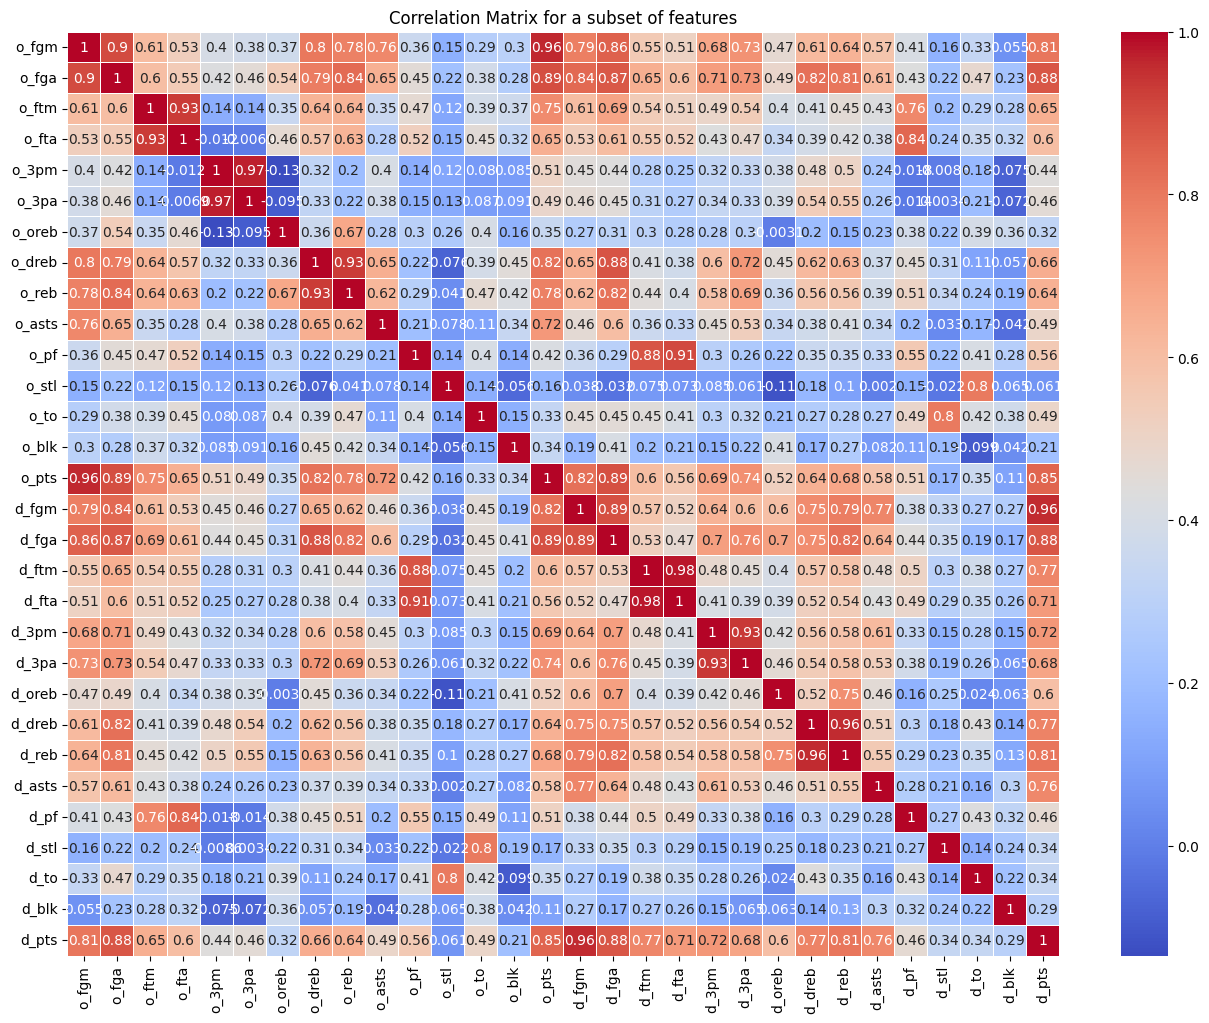

In [34]:
# Select a subset of features
features = ['o_fgm', 'o_fga', 'o_ftm', 'o_fta', 'o_3pm', 'o_3pa',
       'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk',
       'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_3pm', 'd_3pa', 'd_oreb',
       'd_dreb', 'd_reb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts']

# Calculate the correlation matrix for the subset of features
corr_matrix = teams[features].corr()

# Create a heatmap to visualize the correlation matrix for the subset of features
plt.figure(figsize=(16, 12))
sbn.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix for a subset of features')
plt.show()

In [35]:
# Drop the columns that are highly correlated
teams.drop(['o_ftm','o_3pm','o_fgm','d_ftm','d_3pm','d_fgm'], axis=1, inplace=True)
teams.drop(['o_oreb', 'o_dreb', 'd_oreb', 'd_dreb'], axis=1, inplace=True)

In [36]:

award_points = {
    'All-Star Game Most Valuable Player': 5,
    'Defensive Player of the Year': 7,
    'Kim Perrot Sportsmanship Award': 0,
    'Most Improved Player': 6,
    'Most Valuable Player': 10,
    'Rookie of the Year': 7,
    'Sixth Woman of the Year': 5,
    'WNBA Finals Most Valuable Player': 9,
    'WNBA All-Decade Team': 10,
    'WNBA All Decade Team Honorable Mention': 5,
    'Coach of the Year': 1
}
awards_players['award_points'] = awards_players['award'].map(award_points)


grouped_df = awards_players.groupby(['playerID', 'year'], as_index=False)['award_points'].sum()

#order it by playerID and then by year
grouped_df = grouped_df.sort_values(by=['playerID', 'year'])


def calculate_last_3_years_sum(player_id, year):
    # Filter the DataFrame for the specific player
    player_data = grouped_df[grouped_df['playerID'] == player_id]
    
    # Get the last 3 years including the current year
    last_years = player_data[(player_data['year'] <= year) & (player_data['year'] > year - 3)]
    
    # Sum the award points, treating non-existent years as 0
    total_points = last_years['award_points'].sum()  # Sum existing points
   
    return total_points

# Add a new column for the last 3 years' sum
grouped_df['last_3_years_sum'] = grouped_df.apply(
    lambda row: calculate_last_3_years_sum(row['playerID'], row['year']), axis=1
)

# Calculate all_time_sum
def calculate_all_time_sum(player_id, current_year):
    # Filter the DataFrame for the specific player
    player_data = grouped_df[grouped_df['playerID'] == player_id]
    
    # Filter for years less than or equal to the current year
    player_data_current_year = player_data[player_data['year'] <= current_year]
    
    # Initialize a variable to hold the sum of award points
    total_points = 0

    # Iterate through the filtered DataFrame
    for index, row in player_data_current_year.iterrows():
        if row["year"] <= current_year:  # Check if the year is less than 5
            total_points += row["award_points"]  # Add award points to total_points

    return total_points

# Add a new column for the all-time sum of points
grouped_df['all_time_sum'] = grouped_df.apply(
    lambda row: calculate_all_time_sum(row['playerID'], row['year']), axis=1
)

# Create a DataFrame for years 1 to 10
years = pd.DataFrame({'year': range(1, 11)})

# Get unique player IDs
unique_players = grouped_df['playerID'].unique()

# Create a DataFrame with all combinations of playerIDs and years
all_combinations = pd.MultiIndex.from_product([unique_players, years['year']], names=['playerID', 'year']).to_frame(index=False)

# Merge with the grouped_df to get existing values
merged_df = all_combinations.merge(
    grouped_df[['playerID', 'year', 'award_points']],
    on=['playerID', 'year'],
    how='left'
)

# Fill NaN values in 'award_points' with 0 (for years with no awards)
merged_df['award_points'] = merged_df['award_points'].fillna(0)

# Add the last_3_years_sum column
merged_df['last_3_years_sum'] = merged_df.apply(
    lambda row: calculate_last_3_years_sum(row['playerID'], row['year']), axis=1
)

# Add the all_time_sum column
merged_df['all_time_sum'] = merged_df.apply(
    lambda row: calculate_all_time_sum(row['playerID'], row['year']), axis=1
)

#shows leslili01w

print(merged_df[merged_df['playerID'] == 'leslili01w'])

       playerID  year  award_points  last_3_years_sum  all_time_sum
270  leslili01w     1           0.0                 0             0
271  leslili01w     2          24.0                24            24
272  leslili01w     3          14.0                38            38
273  leslili01w     4           0.0                38            38
274  leslili01w     5          17.0                31            55
275  leslili01w     6           0.0                17            55
276  leslili01w     7          20.0                37            75
277  leslili01w     8           0.0                20            75
278  leslili01w     9           7.0                27            82
279  leslili01w    10           0.0                 7            82


In [37]:
#head of players_teams


merged_result = pd.merge(merged_df, players_teams, on=['playerID', 'year'], how='inner')


#list all attributes
merged_result.columns

def calculate_last_3_years_sum_column(player_id, year,column):
    # Filter the DataFrame for the specific player
    player_data = merged_result[merged_result['playerID'] == player_id]
    
    # Get the last 3 years including the current year
    last_years = player_data[(player_data['year'] <= year) & (player_data['year'] > year - 3)]
    
    
    total_points = last_years[column].sum()  # Sum existing points
   
    return total_points



#using the func calculate_last_3_years_sum_column do:
#gp
merged_result['last_3_years_gp'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'GP'), axis=1
)
#GS
merged_result['last_3_years_gs'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'GS'), axis=1
)
#minutes
merged_result['last_3_years_minutes'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'minutes'), axis=1
)
#points
merged_result['last_3_years_points'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'points'), axis=1
)
#oRebounds
merged_result['last_3_years_oRebounds'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'oRebounds'), axis=1
)
#dRebounds
merged_result['last_3_years_dRebounds'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'dRebounds'), axis=1
)
#assists
merged_result['last_3_years_assists'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'assists'), axis=1
)
#steals
merged_result['last_3_years_steals'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'steals'), axis=1
)
#blocks
merged_result['last_3_years_blocks'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'blocks'), axis=1
)
#turnovers
merged_result['last_3_years_turnovers'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'turnovers'), axis=1
)
#PF
merged_result['last_3_years_PF'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'PF'), axis=1
)
#fgAttempted
merged_result['last_3_years_fgAttempted'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'fgAttempted'), axis=1
)
#fgMade
merged_result['last_3_years_fgMade'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'fgMade'), axis=1
)
#ftAttempted
merged_result['last_3_years_ftAttempted'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'ftAttempted'), axis=1
)
#ftMade
merged_result['last_3_years_ftMade'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'ftMade'), axis=1
)
#sera q vale a pena fazer % para isto?
#3ptAttempted
merged_result['last_3_years_3ptAttempted'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'threeAttempted'), axis=1
)
#3ptMade
merged_result['last_3_years_3ptMade'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'threeMade'), axis=1
)
#dq
merged_result['last_3_years_dq'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'dq'), axis=1
)
#PostGP
merged_result['last_3_years_PostGP'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'PostGP'), axis=1
)
#PostGS
merged_result['last_3_years_PostGS'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'PostGS'), axis=1
)
#PostMinutes
merged_result['last_3_years_PostMinutes'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'PostMinutes'), axis=1
)
#PostPoints
merged_result['last_3_years_PostPoints'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'PostPoints'), axis=1
)
#PostoRebounds
merged_result['last_3_years_PostoRebounds'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'PostoRebounds'), axis=1
)
#PostdRebounds
merged_result['last_3_years_PostdRebounds'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'PostdRebounds'), axis=1
)
#PostAssists
merged_result['last_3_years_PostAssists'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'PostAssists'), axis=1
)
#PostSteals
merged_result['last_3_years_PostSteals'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'PostSteals'), axis=1
)
#PostBlocks
merged_result['last_3_years_PostBlocks'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'PostBlocks'), axis=1
)
#PostTurnovers
merged_result['last_3_years_PostTurnovers'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'PostTurnovers'), axis=1
)
#PostPF
merged_result['last_3_years_PostPF'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'PostPF'), axis=1
)
#PostfgAttempted
merged_result['last_3_years_PostfgAttempted'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'PostfgAttempted'), axis=1
)
#PostfgMade
merged_result['last_3_years_PostfgMade'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'PostfgMade'), axis=1
)
#PostftAttempted
merged_result['last_3_years_PostftAttempted'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'PostftAttempted'), axis=1
)
#PostftMade
merged_result['last_3_years_PostftMade'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'PostftMade'), axis=1
)
#Post3ptAttempted
merged_result['last_3_years_Post3ptAttempted'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'PostthreeAttempted'), axis=1
)
#Post3ptMade
merged_result['last_3_years_Post3ptMade'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'PostthreeMade'), axis=1
)
#PostDQ
merged_result['last_3_years_Post3ptMade'] = merged_result.apply(
    lambda row: calculate_last_3_years_sum_column(row['playerID'], row['year'],'PostDQ'), axis=1
)




merged_result.head(10)


,playerID,year,award_points,last_3_years_sum,all_time_sum,stint,tmID,GP,GS,minutes,...,last_3_years_PostSteals,last_3_years_PostBlocks,last_3_years_PostTurnovers,last_3_years_PostPF,last_3_years_PostfgAttempted,last_3_years_PostfgMade,last_3_years_PostftAttempted,last_3_years_PostftMade,last_3_years_Post3ptAttempted,last_3_years_Post3ptMade
0,arcaija01w,1,0.0,0,0,0,HOU,32,32,977,...,10,0,16,14,47,21,7,6,7,0
1,arcaija01w,2,6.0,6,6,0,HOU,32,32,1154,...,12,0,21,19,81,34,9,8,15,0
2,arcaija01w,3,0.0,6,6,0,HOU,32,32,1116,...,17,1,26,30,116,49,17,15,22,0
3,arcaija01w,4,0.0,6,6,0,HOU,34,34,1136,...,15,1,17,21,100,40,23,21,20,0
4,arcaija01w,6,0.0,0,6,0,HOU,34,34,1079,...,14,0,9,10,64,28,25,24,6,0
5,augusse01w,7,7.0,7,7,0,MIN,34,34,1124,...,0,0,0,0,0,0,0,0,0,0
6,augusse01w,8,0.0,7,7,0,MIN,34,34,1093,...,0,0,0,0,0,0,0,0,0,0
7,augusse01w,9,0.0,7,7,0,MIN,31,31,1042,...,0,0,0,0,0,0,0,0,0,0
8,augusse01w,10,0.0,0,7,0,MIN,6,6,178,...,0,0,0,0,0,0,0,0,0,0
9,beviltu01w,1,0.0,0,0,0,POR,32,32,796,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# Export the cleaned dataframes to CSV files
#merged.to_csv("../data/clean/merged.csv", index=False)